# Sequências - Aula Prática 02/04
## RNNs (Recurrent Neural Networks)

Neste notebook iremos trabalhar com a abordagem inicial de redes neurais recorrentes (RNNs), implementando **do zero** uma RNN utilizando PyTorch. Além disso, iremos usar RNNs para para realizar uma classificação de nomes a nível de caractere.

> Em mais detalhes, queremos fazer uma associação de *nome* para *idioma*, processando caractere por caractere do nome de entrada. Ou seja, dado o nome `Satoshi`, iremos processar o nome como uma sequência: `S -> a -> t -> ... -> i`, classificando esse nome como sendo japonês.

- Esse notebook foi fortemente inspirado no primeiro tutorial da série [NLP From Scratch](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html), disponibilizado no site do PyTorch.

## Importação de pacotes

In [1]:
import torch
import random
import unicodedata

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.nn.utils.rnn as rnn_utils

import matplotlib.pyplot as plt

from glob import glob
from tqdm.notebook import tqdm
from collections import defaultdict
from torch.utils.data import Dataset, DataLoader

In [2]:
# Verificando se temos CUDA disponível e selecionando o device que será utilizado
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device escolhido:', device)

Device escolhido: cuda


## Entendimento da base de dados

Durante esse notebook, iremos trabalhar com os dados localizados na pasta `../data/names/`. Nela, você verá 18 arquivos `.txt` separados por idiomas, onde cada arquivo contém uma lista de nomes daquele idioma.

> Por exemplo, explorando o arquivo `Japanese.txt` conseguimos ler nomes como: Akita, Amori, Saito, ...

Antes de entrar na parte do modelo recorrente propriamente dito, iremos ler os dados da pasta `names/` e processá-los de acordo com as nossas necessidades. Primeiramente, iremos armazenar todos os nomes em um dicionário que mapeia `idioma -> lista de nomes`.

- Para carregar o caminho de todos os arquivos da pasta `names/`, iremos usar o módulo nativo do Python: `glob`.

In [3]:
filepaths = glob('../data/names/*.txt')  # * aqui quer dizer "qualquer string"
filepaths

['../data/names/Arabic.txt',
 '../data/names/Chinese.txt',
 '../data/names/Czech.txt',
 '../data/names/Dutch.txt',
 '../data/names/English.txt',
 '../data/names/French.txt',
 '../data/names/German.txt',
 '../data/names/Greek.txt',
 '../data/names/Irish.txt',
 '../data/names/Italian.txt',
 '../data/names/Japanese.txt',
 '../data/names/Korean.txt',
 '../data/names/Polish.txt',
 '../data/names/Portuguese.txt',
 '../data/names/Russian.txt',
 '../data/names/Scottish.txt',
 '../data/names/Spanish.txt',
 '../data/names/Vietnamese.txt']

<br> Aqui podemos observar os 5 primeiros nomes da lista de nomes de idioma arábico.

In [4]:
!head -n 5 ../data/names/Arabic.txt

Khoury
Nahas
Daher
Gerges
Nazari


## Processamento da base de dados

Com os caminhos definidos, conseguimos montar o dicionário mencionado anteriormente.

Para obter o idioma referente à um arquivo, podemos usar a função `get_language`, definida logo abaixo.

In [5]:
def get_language(filepath):
    filename = filepath.split('/')[-1]  # separando a string por '/' e pegando a última posição <language>.txts
    language = filename.split('.')[0]  # separando a string por '.' e pegando a primeira posição (linguagem)

    return language

print('Primeiro filepath:', filepaths[0])
print('Idioma do primeiro filepath:', get_language(filepaths[0]))

Primeiro filepath: ../data/names/Arabic.txt
Idioma do primeiro filepath: Arabic


In [6]:
languages = [] 
language_names = defaultdict(list)  # defaultdict é igual à um dict normal, porém não precisamos verificar
                                    # manualmente se uma entrada já foi inicializada, nesse caso com uma lista vazia

for filepath in filepaths:
    language = get_language(filepath)
    languages.append(language)
    
    with open(filepath, 'r') as fp:
        lines = fp.readlines()  # convertendo as linhas de um arquivo em uma lista de linhas

        for line in lines:
            line = line.strip()  # removendo \n e espaços no começo e fim da string
            language_names[language].append(line)

print('5 primeiros nomes em árabe:', language_names['Arabic'][:5])
print('Idiomas disponíveis no conjunto de dados:', languages)

5 primeiros nomes em árabe: ['Khoury', 'Nahas', 'Daher', 'Gerges', 'Nazari']
Idiomas disponíveis no conjunto de dados: ['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese']


Como estamos trabalhando com palavras de idiomas que possuem caracteres especiais em seus nomes, como por exemplo: Ślusàrski, é uma boa prática de se converter todas as palavras de Unicode (que permite tais caracteres) para um formato ASCII puro, para evitar problemas de `coding` e afins. Para isso, podemos usar a função `unicode2ascii`, definida logo abaixo.

> O código de `unicode2ascii` foi extraído do seguinte [fórum](https://stackoverflow.com/a/518232/2809427) do Stack Overflow. Não se preocupe em entender a lógica por trás dele, mas sim que ele apenas converte de um formato para outro, efetivamente removendo tais caracteres "diferentões".

Antes de utilizar a função `unicode2ascii` precisamos mapear todas as letras pertencentes a nossa base de dados.

In [7]:
all_letters = set()

for names in language_names.values():
    for name in names:
        for letter in name:
            all_letters.add(letter)

print(f'Temos {len(all_letters)} letras distintas na nossa base de dados')

Temos 82 letras distintas na nossa base de dados


In [8]:
def unicode2ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print('Conversão do nome Ślusàrski para ASCII:', unicode2ascii('Ślusàrski'))

Conversão do nome Ślusàrski para ASCII: Slusarski


Seguindo as ideias trabalhadas em notebooks passados, precisamos criar um mapeamento entre *tokens* e índices. No nosso caso, o *token* é uma letra do nosso alfabeto. Para isso, iremos construir nosso alfabeto (vocabulário), com base nas letras únicas de todos os nomes da base de dados, e, posteriormente, iremos criar 2 estruturas para realizar tal mapeamento: `letter2index` e `index2letter`.

> Além dos *tokens* obtidos através do texto, é muito comum vermos também outros 3 *tokens* especiais:
> - **\<sos\>**: abreviação para *start-of-sequence*, ou início de sentença.
> - **\<eos\>**: abreviação para *end-of-sequence*, ou fim de sentença.
> - **\<pad\>**: *token* especial destinado para indicar um valor de *pad* na nossa sequência.

- Para esse notebook, os *tokens* de **\<sos\>** e **\<eos\>** não serão tão úteis assim, uma vez que eles são utilizados mais em arquiteturas *encoder-decoder* e para geração de sentenças. Já o *token* **\<pad\>** será útil para podermos trabalhar com a ideia de *batches*, mesmo em dados de tamanho variável (que é o nosso caso). Porém, para manter a simplicidade e o propósito deste notebook, não iremos trabalhar com *batches* por enquanto.

In [9]:
vocabulary = set()
for letter in all_letters:
    letter = unicode2ascii(letter)
    vocabulary.add(letter)

vocabulary = list(vocabulary)
print('Tamanho do alfabeto:', len(vocabulary))
print('5 tokens aleatórios do alfabeto:', random.choices(vocabulary, k=5))

Tamanho do alfabeto: 57
5 tokens aleatórios do alfabeto: ['R', 'F', 'Q', 'W', 'C']


In [10]:
index2letter = []
letter2index = {}

for token_idx, token in enumerate(vocabulary):
    index2letter.append(token)
    letter2index[token] = token_idx

print('Token de índice 42:', index2letter[42])
print('Índice do token "A":', letter2index['A'])

Token de índice 42: e
Índice do token "A": 32


Agora que temos as estruturas `index2letter` e `letter2index` bem definidas, conseguimos converter um nome em um tensor de índices numéricos através da função `name2tensor`, como demonstrado a seguir.

> **Observação:** Criaremos um tensor de tamanho $n \times 1$, onde $n$ é o tamanho do nome e $1$ o tamanho do nosso *batch*. Para esse notebook, nós não iremos trabalhar com `batch_size > 1`, devido à complicações relacionadas com manipulação de sequências e *padding*. Deixaremos tais assuntos para serem abordados no notebook de `seq2seq`.

- Optamos por trocar a ordem padrão das dimensões dos dados em PyTorch, ou seja, com o tamanho do *batch* no começo, para facilitar operações em sequências no futuro, como utilizar `len` para obter o tamanho da sequência e tornar a indexação mais fácil. Na verdade, especificamente para sequências, PyTorch nos dá a opção de colocar o tamanho do *batch* como primeira dimensão do nosso tensor ou na segunda, sendo a primeira o tamanho da nossa sequência. Veremos isso em mais detalhes quando trabalharmos com os modelos recorrentes implementados pelo PyTorch.

In [11]:
def name2tensor(name):
    tensor = torch.zeros((len(name), 1), dtype=torch.long)
    for idx, letter in enumerate(name):
        tensor[idx] = letter2index[letter]

    return tensor

name = 'Jonas'
print(f'Tensor para o nome {name}: {name2tensor(name).T}')  # transposição para fins de print

Tensor para o nome Jonas: tensor([[39, 37, 56, 50, 17]])


Para finalizar essa parte do notebook sobre dados, iremos criar uma função auxiliar `get_random_pair` para selecionar de forma aleatória um par `(nome, idioma)` da nossa base dados. Além disso, tal função irá retornar os tensores relacionados com cada componente do par.

- Por ora não iremos nos preocupar com a separação entre conjuntos de treino, validação e teste. O objetivo desse notebook é de ensinar como trabalhamos do zero com dados sequenciais, e também como implementar do zero uma rede neural recorrente simples.

In [12]:
def get_random_pair():
    language = random.choice(languages)
    name = random.choice(language_names[language])

    name = unicode2ascii(name)
    name_tensor = name2tensor(name)
    language_tensor = torch.tensor([languages.index(language)], dtype=torch.long)

    return name, language, name_tensor, language_tensor

In [13]:
name, language, name_tensor, language_tensor = get_random_pair()

print('Par selecionado:', (name, language))
print('Tensores do par:', (name_tensor.T, language_tensor))

Par selecionado: ('Moon', 'Korean')
Tensores do par: (tensor([[ 8, 37, 37, 56]]), tensor([11]))


## Finalmente... RNNs

Primeiramente, vamos relembrar como que funciona uma camada de uma rede neural *feed-forward*. A operação feita por essa camada é representada pela seguinte equação:

\begin{align*}
    f(X) = \sigma (W_{xh}X + b_h)
\end{align*}

sendo,
- $X \in \mathbb{R}^{b \times d}$ o dado de entrada, sendo $b$ o número de amostras do nosso *batch* e $d$ a dimensão de cada amostra.
- $W_{xh} \in \mathbb{R}^{d \times h}$ a matriz de pesos que "leva" $X$, de dimensão $d$, para uma dimensão de saída $h$.
- $b_h \in \mathbb{R}^{1 \times h}$ o viés relacionado com a matriz de pesos $W_{xh}$.
- $\sigma$ uma função de ativação não linear qualquer.

O resultado dessa operação é $f(X) \in \mathbb{R}^{b \times h}$, podendo ser usado tanto como uma feature intermediária para outras camadas neurais, quanto a saída final do modelo.

No começo do curso, vimos que esse tipo de operação pode ser computada através da camada `nn.Linear` do PyTorch.

In [14]:
x = torch.rand(1, 10)  # um tensor aleatório com b = 1 e d = 10
linear = nn.Linear(10, 5, bias=True)  # por padrão o viés sempre será igual à True, estamos apenas explicitando isso

linear(x).shape

torch.Size([1, 5])

Uma rede neural recorrente, por outro lado, é uma função não só de $X$, mas também de um *hidden state* $H \in R^{b \times h}$, que representa a memória interna da unidade recorrente. Em outras palavras, a unidade recorrente é uma função da entrada atual $X^{<t>}$ e do conhecimento prévio acumulado $H^{<t-1>}$, onde $t$ representa o *timestep* atual.

Para comportar essa mudança em uma rede neural *feed-forward*, basta adicionarmos uma matriz de pesos $W_{hh} \in R^{h \times h}$, que irá operar com a memória interna de *timesteps* anteriores, ou seja:

\begin{align*}
f(X^{<t>}, H^{<t-1>}) = \sigma (W_{xh}X^{<t>} + W_{hh}H^{<t-1>} + b_h)
\end{align*}

Redes neurais recorrentes operam sobre processos **iterativos**, que devem ser executado com todos os elementos $X^{<t>}$ da sequência de entrada $X = \{X^{<1>}, X^{<2>}, \dots , X^{<n>}\}$, sendo $n$ o tamanho da sequência. O *forward* do nosso modelo irá produzir um conjunto de *hidden states* $H = \{H^{<1>}, H^{<2>}, \dots, H^{<n>}\}$, como observado na imagem a seguir, onde temos uma "versão compacta" (esquerda) e "desenrolada" (direita) da rede.

![](../imagens/diagrama_rnn.png)

> **Atenção:** Na primeira iteração, o *hidden state* $H^{<0>}$ deve ser inicializado. Existem vários métodos de inicialização, sendo os mais comuns inicialização aleatória ou com zeros.

Além disso, podemos utilizar as saídas $H$ para computar predições em cada instante de tempo $t$, permitindo a modelagem dos vários tipos de modelos recorrentes, como modelos *one-to-many*, *many-to-one* e *many-to-many*. A equação completa de uma RNN, seguindo essa ideia fica da seguinte forma:

\begin{align*}
H^{<t>} &= \sigma_1 (W_{xh}X^{<t>} + W_{hh}H^{<t-1>} + b_h) \\
\hat{y}^{<t>} &= \sigma_2 (W_{hy}H^{<t>} + b_y)
\end{align*}

sendo,
- $\sigma_1$ e $\sigma_2$, funções de ativações não lineares. Tipicamente $\sigma_1 = \text{tanh}$ e $\sigma_2$ varia de problema para problema.
- $W_{hy} \in \mathbb{R}^{h \times c}$ a matriz de pesos que "leva" $H^{<t>}$, de dimensão $h$, para uma dimensão de saída $c$ (dimensão da predição).
- $b_y \in \mathbb{R}^{1 \times c}$ o viés relacionado com a matriz de pesos $W_{hy}$.

Tudo isso pode ser feito em PyTorch através de uma combinação de unidades ``nn.Linear``, porém, para ficar mais próximo da equação demonstrada anteriormente, iremos definir tensores que podem ser aprendidos através da classe ``nn.Parameter``.

In [15]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()

        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size, hidden_size, bias=False)  # isso cuida de Wxh @ X^<t>
        self.h2h = nn.Linear(hidden_size, hidden_size)  # isso cuida de Whh @ H^<t-1> + bh
        self.h2o = nn.Linear(hidden_size, output_size)  # isso cuida de Why @ H^<t> + by

        # Definindo funções de ativação
        self.tanh = nn.Tanh()
        self.softmax = nn.LogSoftmax(dim=-1)  # a última dimensão será a dimensão das predições
    
    def forward(self, x, prev_hidden):
        hidden = self.tanh(self.i2h(x) + self.h2h(prev_hidden))
        output = self.softmax(self.h2o(hidden))

        return output, hidden
        
    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

Suponha que após aplicarmos o *embedding*, nós tenhamos a matriz `X`, cujas dimensões são: $S \times 1 \times E$, onde $S$ é o tamanho da sequência e $E$ o tamanho do *embedding* escolhido. Uma passagem desse dado pela rede definida anteriormente, será dado da seguinte forma.

> Para esse exemplo utilizamos: $S = 4$, $E = 2$, $h = 8$ e estaremos prevendo 10 classes.

In [16]:
seq_length = 4
embedding_size = 2
X = torch.rand(seq_length, 1, embedding_size)  # definindo uma matriz X aleatória apenas para exemplo

hidden_size = 8
output_size = 10

model = RNN(embedding_size, hidden_size, output_size)
hidden = model.init_hidden()

for Xt in X:
    outputs, hidden = model(Xt, hidden)

print('Tamanho do output final:', outputs.shape)
print('Tamanho do hidden final:', hidden.shape)

Tamanho do output final: torch.Size([1, 10])
Tamanho do hidden final: torch.Size([1, 8])


Para encerrar essa seção e finalmente treinar o nosso modelo, iremos comentar brevemente que o PyTorch já disponibiliza para a gente um módulo `nn.RNN` para trabalhar com modelos neurais recorrentes simples. A documentação desse módulo pode ser encontrada [aqui](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html#rnn). Porém, fiquem tranquilos que iremos abordar ele em mais detalhes nos próximos notebooks.

> **Observação 01:** Também podemos "empilhar" RNNs da mesma forma que "empilhamos" redes neurais *feed-forward*. Para isso, basta definirmos uma segunda RNN que admite como entrada um `hidden_size`, ao invés do tamanho do embedding escolhido!
> 
> **Observação 02:** Devido a forma de como o PyTorch implementa modelos recorrentes, transformar um código que usa RNNs para outro que usa, por exemplo, LSTMs e GRUs (ou até mesmo Transformers!) acaba sendo relativamente fácil. Veremos isso em mais detalhes nos próximos dias.

## Treinamento do modelo final

Para unir todos os conceitos relacionados com modelos que vimos até então: *embeddings* + *RNNs*, iremos criar um "super" modelo `NameClassificationModel` para realizar todo o *pipeline* de processamento dos dados por parte dos modelos neurais.

In [17]:
class NameClassificationModel(nn.Module):
    def __init__(self, vocabulary_size, embedding_size, hidden_size, output_size):
        super().__init__()

        self.embedding = nn.Embedding(vocabulary_size, embedding_size)
        self.rnn = RNN(embedding_size, hidden_size, output_size)

    def forward(self, x):
        x = self.embedding(x)

        hidden = self.rnn.init_hidden().to(device)
        for xt in x:
            output, hidden = self.rnn(xt, hidden)

        # Como não estamos interessados na memória, iremos apenas retornar o último output
        return output

Criaremos uma função auxiliar para retornar a classe predita pelo modelo (idioma e seu índice).

In [18]:
def get_language_from_output(output):
    idx = torch.argmax(output, dim=-1)  # as predições estarão na última dimensão do tensor
    return languages[idx]

In [19]:
# Verificando se o modelo retorna aquilo que esperamos
hidden_size = 32
embedding_size = 16

model = NameClassificationModel(len(vocabulary), embedding_size, hidden_size, len(languages))
model = model.to(device)

name, language, name_tensor, language_tensor = get_random_pair()
name_tensor = name_tensor.to(device)
language_tensor = language_tensor.to(device)

output = model(name_tensor)
print('Entrada do modelo:', (name, language))
print('Dimensão da saída do modelo:', output.shape)
print('Predição do modelo:', get_language_from_output(output))

Entrada do modelo: ('Baiburski', 'Russian')
Dimensão da saída do modelo: torch.Size([1, 18])
Predição do modelo: Dutch


Realizando o loop de treinamento.

> Como o nosso modelo recorrente possui como última camada uma `LogSoftmax`, iremos utilizar a função de perda `nn.NLLLoss` (*negative log-likelihood*), que espera log-probabilidades como saída da rede. Um fato curioso é que `nn.CrossEntropyLoss = LogSoftmax + nn.NLLLoss`, segundo a própria [documentação](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) da `nn.CrossEntropyLoss`.

In [20]:
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.005)

loss_interval = 1000  # intervalo para salvar a loss média
print_interval = 5000  # intervalo para exibir performance da rede
num_iterations = 100000

# Variáveis para manter o valor da loss ao longo das épocas
all_losses = []
current_loss = 0

for iter in tqdm(range(1, num_iterations + 1)):
    name, language, name_tensor, language_tensor = get_random_pair()
    
    name_tensor = name_tensor.to(device)
    language_tensor = language_tensor.to(device)

    output = model(name_tensor)
    loss = criterion(output, language_tensor)
    current_loss += loss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if iter % print_interval == 0:
        guess = get_language_from_output(output)
        correct = '✓' if guess == language else f'✗ ({language})'
        print(f'Iter [{iter}/{num_iterations}] => loss: {loss:.5f}, {name} is {guess} {correct}')

    if iter % loss_interval == 0:
        all_losses.append(current_loss / loss_interval)
        current_loss = 0

  0%|          | 0/100000 [00:00<?, ?it/s]

Iter [5000/100000] => loss: 3.79436, Feetham is Vietnamese ✗ (English)
Iter [10000/100000] => loss: 0.33757, Hatayama is Japanese ✓
Iter [15000/100000] => loss: 3.11423, Smit is Russian ✗ (Dutch)
Iter [20000/100000] => loss: 0.09200, Warszawski is Polish ✓
Iter [25000/100000] => loss: 1.62559, Wardle is French ✗ (English)
Iter [30000/100000] => loss: 1.62129, Worthington is Scottish ✗ (English)
Iter [35000/100000] => loss: 1.79939, Gross is Dutch ✗ (German)
Iter [40000/100000] => loss: 1.74340, Costa is Spanish ✗ (Portuguese)
Iter [45000/100000] => loss: 1.36993, Smeets is English ✗ (Dutch)
Iter [50000/100000] => loss: 0.42162, Asghar is Arabic ✓
Iter [55000/100000] => loss: 0.17617, Grimaldi is Italian ✓
Iter [60000/100000] => loss: 0.38735, Huie is Chinese ✓
Iter [65000/100000] => loss: 1.07587, Nepi is Italian ✓
Iter [70000/100000] => loss: 0.17285, Obyedkin is Russian ✓
Iter [75000/100000] => loss: 0.07319, Vestri is Italian ✓
Iter [80000/100000] => loss: 0.72164, Riha is Czech ✓
I

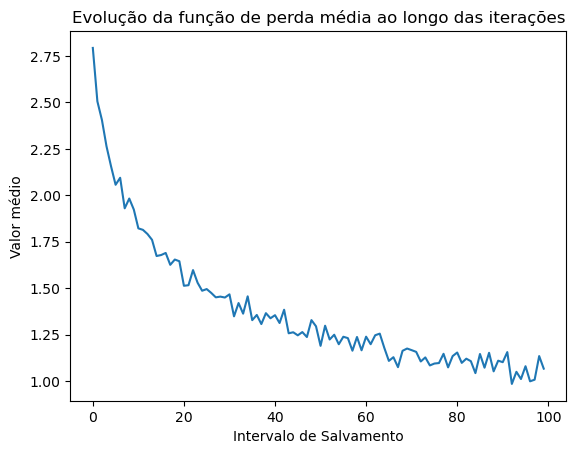

In [21]:
plt.title('Evolução da função de perda média ao longo das iterações')
plt.xlabel('Intervalo de Salvamento')
plt.ylabel('Valor médio')

# Convertendo de Torch CUDA para arrays numpy
for i in range(len(all_losses)):
    all_losses[i] = all_losses[i].detach().cpu().numpy()
    
plt.plot(all_losses)
plt.show()

## Avaliando os resultados obtidos

Para verificar o desempenho da rede em diferentes idiomas, criaremos uma matriz de confusão, indicando para cada idioma real (linhas) qual idioma a rede adivinha (colunas). Para calcular a matriz de confusão, uma quantia grande de amostras, definida pela variável `num_confusion_samples`, serão processadas pela rede em modo de avaliação.

  0%|          | 0/10000 [00:00<?, ?it/s]

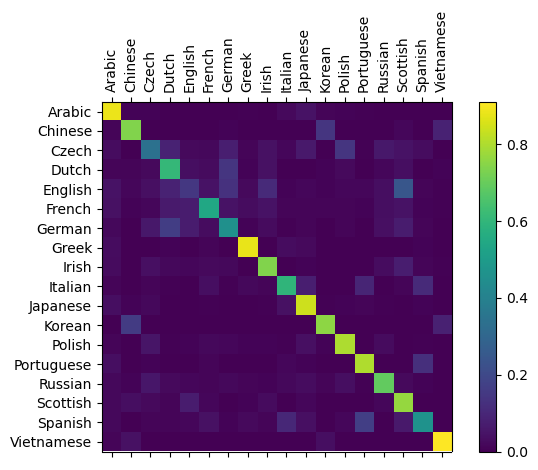

In [22]:
num_confusion_samples = 10000
confusion_matrix = torch.zeros(len(languages), len(languages))

model.eval()
with torch.no_grad():
    for i in tqdm(range(num_confusion_samples)):
        name, language, name_tensor, language_tensor = get_random_pair()

        name_tensor = name_tensor.to(device)
        language_tensor = language_tensor.to(device)

        output = model(name_tensor)
        guess = get_language_from_output(output)

        guess_idx = languages.index(guess)
        language_idx = languages.index(language)

        confusion_matrix[language_idx, guess_idx] += 1

# Normalizando as linhas da matriz de confusão
for i in range(len(languages)):
    confusion_matrix[i] /= confusion_matrix[i].sum()

# Configurando o plot
fig, ax = plt.subplots()

img = ax.matshow(confusion_matrix.numpy())
fig.colorbar(img)

ax.set_xticks(range(len(languages)), languages, rotation=90)
ax.set_yticks(range(len(languages)), languages)

fig.tight_layout()

## Verificando as top 3 predições da rede

In [23]:
def predict(name):
    print(f'\n> {name}')

    model.eval()
    with torch.no_grad():
        name_tensor = name2tensor(name).to(device)
        output = model(name_tensor)

        vals, idxs = torch.topk(output[0], k=3, dim=-1)
        for val, idx in zip(vals, idxs):
            prob = torch.e ** val  # probabilidade = exp(log-probabilidade)
            print(f'({prob:.2f}) {languages[idx]}')
            
predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(0.58) Russian
(0.13) Scottish
(0.12) Czech

> Jackson
(0.86) Scottish
(0.06) English
(0.03) Russian

> Satoshi
(0.81) Japanese
(0.08) Arabic
(0.06) Greek


Iremos pegar um exemplo que não está na base de dados: `Thiago`

In [24]:
has_thiago = 'Thiago' in language_names['Portuguese']
print(f'A base de dados contém o nome "Thiago"? {has_thiago}')

A base de dados contém o nome "Thiago"? False


In [30]:
predict('Thiago')


> Thiago
(0.70) Japanese
(0.11) Portuguese
(0.06) Spanish
